In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
from feature_matcher import SIFTFeatureMatcher, FASTBRIEFFeatureMatcher, ORBFeatureMatcher
fms = [SIFTFeatureMatcher(), FASTBRIEFFeatureMatcher(), ORBFeatureMatcher()]

In [3]:
img_source = cv2.cvtColor(cv2.imread('img/source.png'), cv2.COLOR_BGR2RGB)
w, h = 256, 256
cx, cy = 210, 290

In [4]:
matrix_distortion0 = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
], dtype=np.float32)

matrix_distortion1 = np.array([
    [ 0.9,  0.05, w / 10],
    [0.1,  0.96, h / 10],
    [ 0.0000,  0.0003,  1]
], dtype=np.float32)

matrix_distortion2 = np.array([
    [0.8, 0.1, w/6],
    [-0.1, 0.9, h/4],
    [0.0005, 0.0002, 1]
], dtype=np.float32)

matrix_distortion3 = np.array([
    [np.cos(5), np.sin(5), w * 0.5],
    [-np.sin(5), np.cos(5), h * 0.2],
    [0.00, 0.001, 1]
], dtype=np.float32)


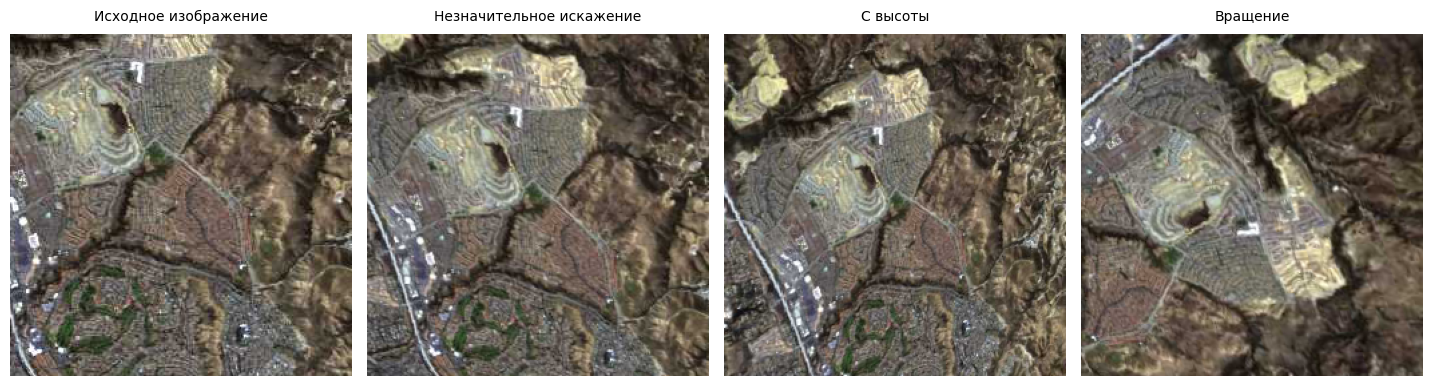

In [5]:
plt.figure(figsize=(18, 6), dpi=100)

img_ideal = cv2.getRectSubPix(img_source, (w, h), (cx, cy))

sx = cx - w // 2
sy = cy - h // 2
matrix_shift = np.array([
    [ 1,  0,  -sx],
    [ 0,  1,  -sy],
    [ 0,  0,  1]
], dtype=np.float32)

distortions = [matrix_distortion0, matrix_distortion1, matrix_distortion2, matrix_distortion3]
titles = ['Исходное изображение', 'Незначительное искажение', 'C высоты', 'Вращение']

for i, (matrix, title) in enumerate(zip(distortions, titles)):
    matrix_combined = matrix @ matrix_shift
    img_distorted = cv2.warpPerspective(img_source, matrix_combined, (w, h), 
                                      borderMode=cv2.BORDER_REFLECT_101)
    
    plt.subplot(152 + i)
    plt.imshow(img_distorted)
    plt.title(title, fontsize=10, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('img/distortion_first_look', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
from haze import set_visibility, make_hazed, prepare_mask

mask1 = prepare_mask(cv2.imread('img/mask1.png', cv2.IMREAD_GRAYSCALE), (512, 512))
mask2 = prepare_mask(cv2.imread('img/mask2.png', cv2.IMREAD_GRAYSCALE), (512, 512))
mask3 = prepare_mask(cv2.imread('img/mask3.png', cv2.IMREAD_GRAYSCALE), (512, 512))
masks = [
    set_visibility(mask1, 1), set_visibility(mask1, 0.75), set_visibility(mask1, 0.5),
    set_visibility(mask2, 1), set_visibility(mask2, 0.75), set_visibility(mask2, 0.5),
    set_visibility(mask3, 1), set_visibility(mask3, 0.75), set_visibility(mask3, 0.5)
]

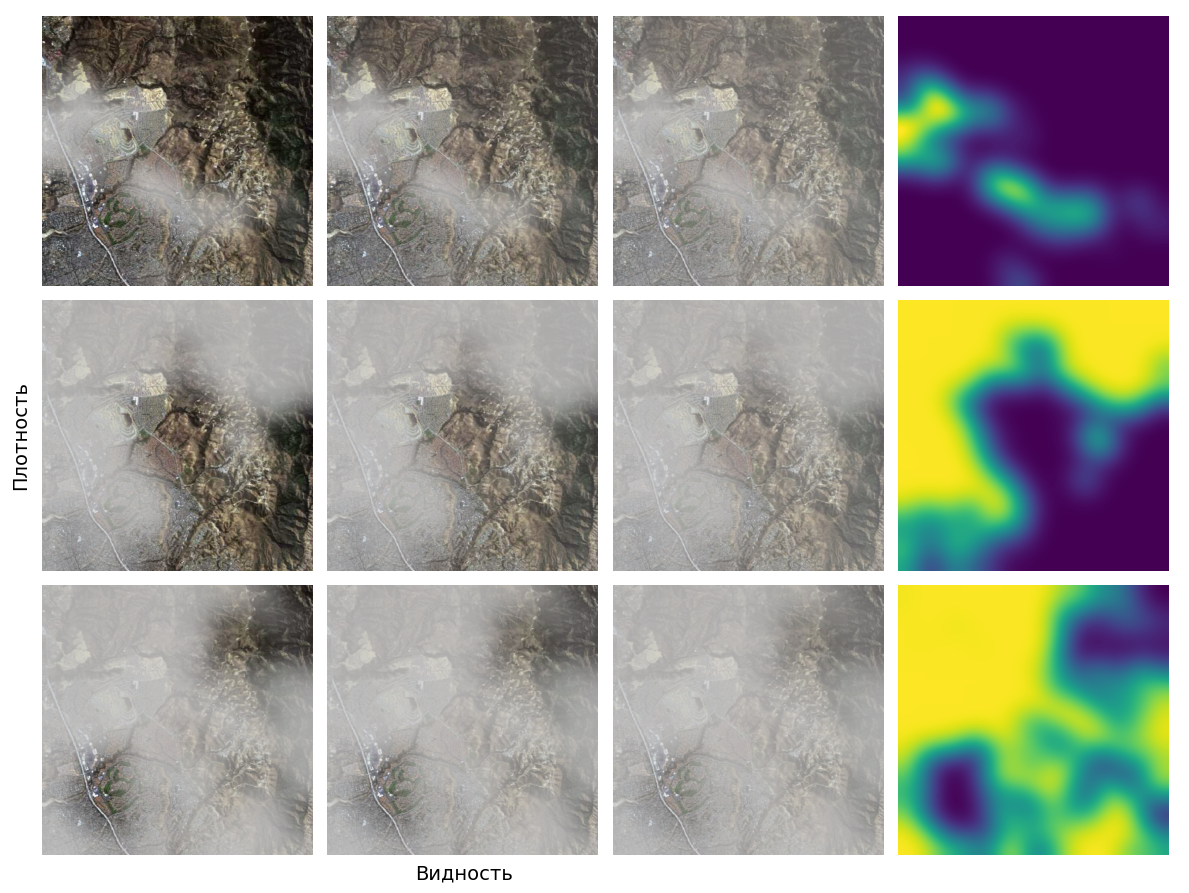

In [8]:
images = [make_hazed(img_source, np.array([0.8, 0.8, 0.8]), 1.8, i) for i in masks]
images[6+3:6+3] = [mask3]
images[3+3:3+3] = [mask2]
images[0+3:0+3] = [mask1]

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

big_ax = fig.add_subplot(111, frameon=False)
big_ax.tick_params(
    labelcolor='none', 
    top=False, 
    bottom=False, 
    left=False, 
    right=False
)
big_ax.set_xlabel("Видность", fontsize=14, labelpad=20)
big_ax.xaxis.set_label_coords(3/8, -0.01)
big_ax.set_ylabel("Плотность", fontsize=14, labelpad=20)
big_ax.yaxis.set_label_coords(-0.01, 1/2)

plt.tight_layout()
plt.savefig('img/haze_classification')
plt.show()
plt.show()

In [9]:
from loss import make_perspective_transform, loss_2, loss_inf

def generate_non_decreasing_triplet():
    x1 = np.random.uniform(0.8, 1.0)
    x2 = np.random.uniform(x1, min(x1 * 1.05, 1.0))
    x3 = np.random.uniform(x2, min(x2 * 1.05, 1.0))
    return np.array([x1, x2, x3])

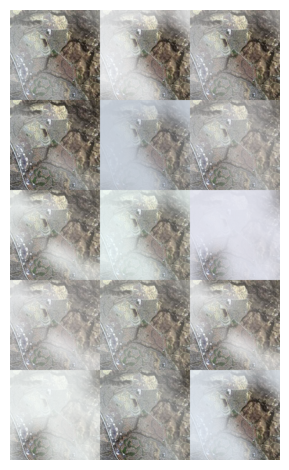

In [10]:
import random

n = 20

images = []
for _ in range(n):
    atmospheric_light = generate_non_decreasing_triplet()
    beta = np.random.uniform(0.5, 3.0)
    for i, depth_map in enumerate(masks):
        img_hazed = make_hazed(img_source, atmospheric_light, beta, depth_map)
        matrix_distortion_and_shift = matrix_distortion1 @ matrix_shift
        img_input = cv2.warpPerspective(img_hazed, matrix_distortion_and_shift, (w, h))

        images.append(img_input)

images = random.sample(images, 3 * 5)
rows = []
for i in range(0, 15, 3):
    row = np.hstack(images[i:i+3])
    rows.append(row)

result_image = np.vstack(rows)
plt.axis('off')
plt.tight_layout()
plt.imshow(result_image)
# plt.savefig('img/haze_example')
plt.show()


In [11]:
import pandas as pd

n = 100

data = []
for _ in range(n):
    atmospheric_light = generate_non_decreasing_triplet()
    beta = np.random.uniform(0.0, 10.0)
    for i, depth_map in enumerate(masks):
        for distortion_type, matrix_distortion in enumerate(distortions):
            img_hazed = make_hazed(img_source, atmospheric_light, beta, depth_map)
            matrix_distortion_and_shift = matrix_distortion @ matrix_shift
            img_input = cv2.warpPerspective(img_hazed, matrix_distortion_and_shift, (w, h))

            for fm in fms:
                row = {
                    'feature_matcher': str(fm),
                    'distortion_type': distortion_type,
                    'atmospheric_light': atmospheric_light, 'beta': beta, 'density_type': i,
                    'loss_2': np.nan,
                    'loss_inf': np.nan
                }
                try:
                    results = fm.process_images(img_ideal, img_input)
                    assert(results['matrix_alg'] is not None)
                except:
                    pass
                else:
                    matrix_alg = results['matrix_alg']
                    transform_vestigial = make_perspective_transform(matrix_alg @ matrix_distortion)
                    region = np.array(list(np.ndindex(w, h)))  # TODO
                    row['loss_2'] = loss_2(transform_vestigial, region)
                    row['loss_inf'] = loss_inf(transform_vestigial, region)
                data.append(row)

In [12]:
loss_threshold = w / 10
df0 = pd.DataFrame(data)
df0['loss_2_processed'] = np.where(df0['loss_2'] < loss_threshold, df0['loss_2'], np.nan)
df0['loss_inf_processed'] = np.where(df0['loss_inf'] < loss_threshold, df0['loss_inf'], np.nan)
df0['atmospheric_light_mean'] = [np.mean(i) for i in df0['atmospheric_light']]
df0['atmospheric_light_std'] = [np.mean(i) for i in df0['atmospheric_light']]
df0

feature_matcher  distortion_type  \
0                SIFT                0   
1          FAST+BRIEF                0   
2                 ORB                0   
3                SIFT                1   
4          FAST+BRIEF                1   
...               ...              ...   
10795      FAST+BRIEF                2   
10796             ORB                2   
10797            SIFT                3   
10798      FAST+BRIEF                3   
10799             ORB                3   

                                       atmospheric_light      beta  \
0      [0.9201807617897367, 0.9301829225062612, 0.973...  6.811982   
1      [0.9201807617897367, 0.9301829225062612, 0.973...  6.811982   
2      [0.9201807617897367, 0.9301829225062612, 0.973...  6.811982   
3      [0.9201807617897367, 0.9301829225062612, 0.973...  6.811982   
4      [0.9201807617897367, 0.9301829225062612, 0.973...  6.811982   
...                                                  ...       ...   
10795  [0.8118272793123091, 0.8515387819087437, 0.866...  7.317025   
10796  [0.8118272793123091, 0.8515387819087437, 0.866...  7.317025   
10797  [0.8118272793123091, 0.8515387819087437, 0.866...  7.317025   
10798  [0.8118272793123091, 0.8515387819087437, 0.866...  7.317025   
10799  [0.8118272793123091, 0.8515387819087437, 0.866...  7.317025   

       density_type     loss_2   loss_inf  loss_2_processed  \
0                 0   0.663845   0.735552          0.663845   
1                 0   1.142999   3.446348          1.142999   
2                 0  15.133173  61.121529         15.133173   
3                 0   0.766306   1.069328          0.766306   
4                 0   1.517672   4.913218          1.517672   
...             ...        ...        ...               ...   
10795             8        NaN        NaN               NaN   
10796             8        NaN        NaN               NaN   
10797             8        NaN        NaN               NaN   
10798             8        NaN        NaN               NaN   
10799             8        NaN        NaN               NaN   

       loss_inf_processed  atmospheric_light_mean  atmospheric_light_std  
0                0.735552                0.941373               0.941373  
1                3.446348                0.941373               0.941373  
2                     NaN                0.941373               0.941373  
3                1.069328                0.941373               0.941373  
4                4.913218                0.941373               0.941373  
...                   ...                     ...                    ...  
10795                 NaN                0.843169               0.843169  
10796                 NaN                0.843169               0.843169  
10797                 NaN                0.843169               0.843169  
10798                 NaN                0.843169               0.843169  
10799                 NaN                0.843169               0.843169  

[10800 rows x 11 columns]

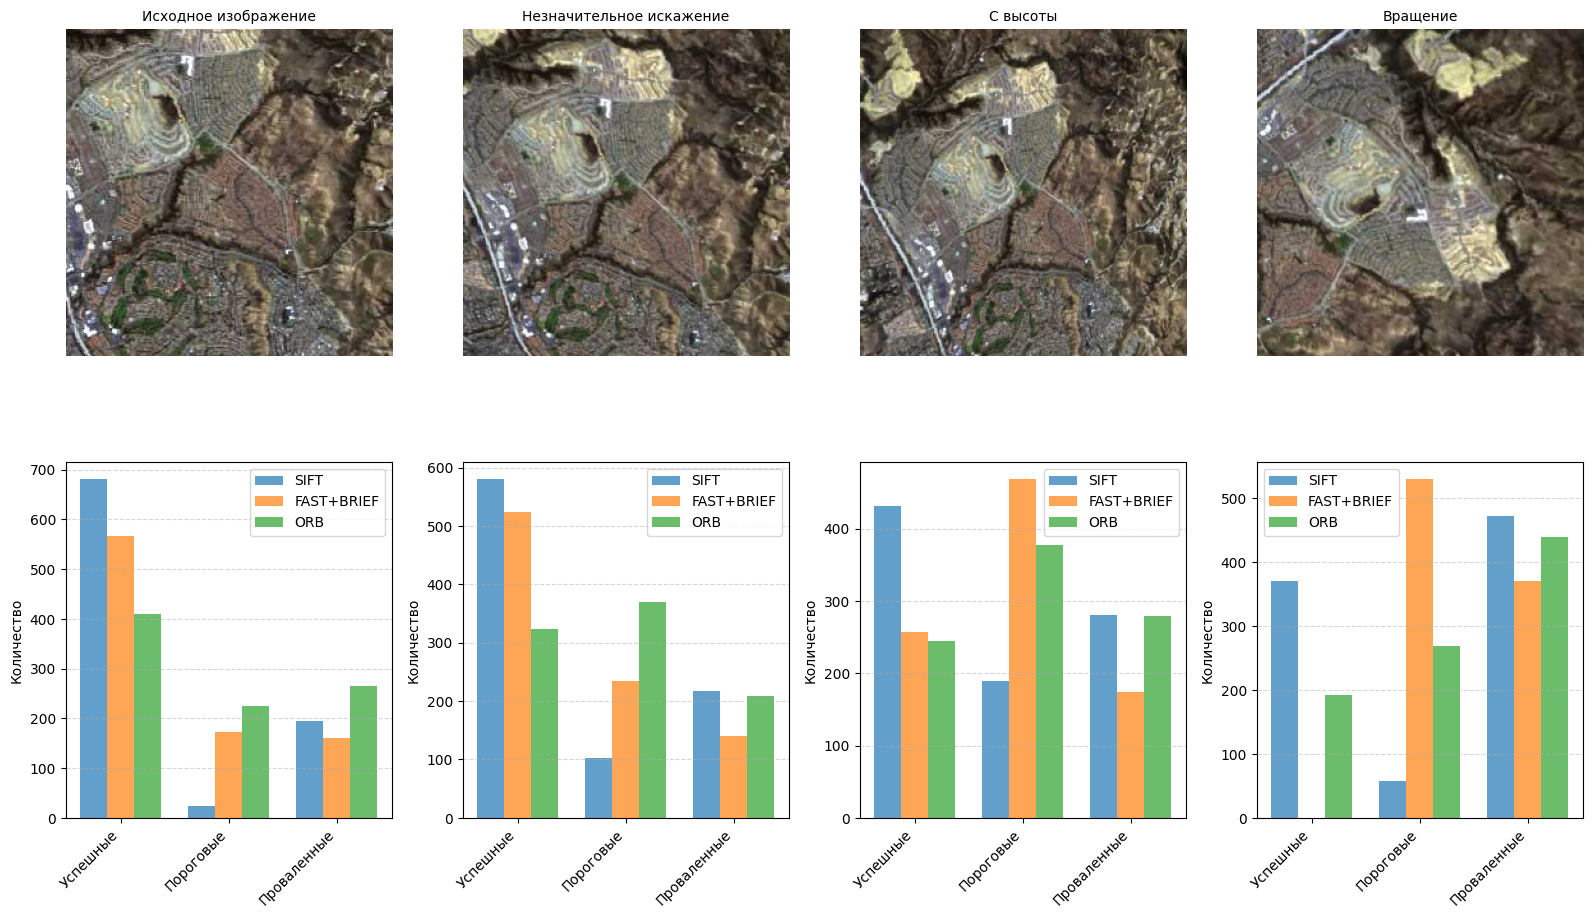

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

metric = 'loss_2'

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 5, figure=fig, height_ratios=[1, 0.7])

distortion_types = df0['distortion_type'].unique()

for i, distortion_type in enumerate(distortion_types):
    ax_img = fig.add_subplot(gs[0, i])
    
    matrix_combined = distortions[distortion_type] @ matrix_shift
    img_distorted = cv2.warpPerspective(img_source, matrix_combined, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    distorted_img = img_distorted
    ax_img.imshow(distorted_img)
    ax_img.set_title(titles[distortion_type], fontsize=10)
    ax_img.axis('off')
    
    ax_bar = fig.add_subplot(gs[1, i])
    
    distortion_group = df0[df0['distortion_type'] == distortion_type]
    grouped = distortion_group.groupby('feature_matcher', sort=False)
    
    categories = ['Успешные', 'Пороговые', 'Проваленные']
    bar_width = 0.25
    x = np.arange(len(categories))
    
    summary_data = []
    for name, group in grouped:
        metrics = group[metric]
        success = (metrics < loss_threshold).sum()
        threshold = ((metrics >= loss_threshold) & metrics.notna()).sum()
        failed = metrics.isna().sum()
        summary_data.append((success, threshold, failed))
    
    for j, (name, (success, threshold, failed)) in enumerate(zip(grouped.groups.keys(), summary_data)):
        ax_bar.bar(x + j * bar_width, [success, threshold, failed],
                  width=bar_width,
                  alpha=0.7,
                  label=name)
    
    ax_bar.set_xticks(x + bar_width*(len(grouped)-1)/2)
    ax_bar.set_xticklabels(categories, rotation=45, ha='right')
    ax_bar.set_ylabel('Количество')
    ax_bar.grid(axis='y', linestyle='--', alpha=0.5)
    
    ax_bar.legend()

plt.tight_layout()
plt.savefig('img/distortion_comparison.png')
plt.show()

In [14]:
matrix_distortion = matrix_distortion1
matrix_distortion_and_shift = matrix_distortion @ matrix_shift

In [15]:
import pandas as pd

n = 750

data = []
for _ in range(n):
    atmospheric_light = generate_non_decreasing_triplet()
    beta = np.random.uniform(0.0, 10.0)
    for i, depth_map in enumerate(masks):
        img_hazed = make_hazed(img_source, atmospheric_light, beta, depth_map)
        img_input = cv2.warpPerspective(img_hazed, matrix_distortion_and_shift, (w, h))
        
        for fm in fms:
            row = {
                'feature_matcher': str(fm),
                'atmospheric_light': atmospheric_light, 'beta': beta, 'density_type': i,
                'loss_2': np.nan,
                'loss_inf': np.nan
            }
            try:
                results = fm.process_images(img_ideal, img_input)
                assert(results['matrix_alg'] is not None)
            except:
                pass
            else:
                matrix_alg = results['matrix_alg']
                transform_vestigial = make_perspective_transform(matrix_alg @ matrix_distortion)
                region = np.array(list(np.ndindex(w, h)))  # TODO
                row['loss_2'] = loss_2(transform_vestigial, region)
                row['loss_inf'] = loss_inf(transform_vestigial, region)
            data.append(row)

In [16]:
loss_threshold = w / 10
df = pd.DataFrame(data)
df['loss_2_processed'] = np.where(df['loss_2'] < loss_threshold, df['loss_2'], np.nan)
df['loss_inf_processed'] = np.where(df['loss_inf'] < loss_threshold, df['loss_inf'], np.nan)
df['atmospheric_light_mean'] = [np.mean(i) for i in df['atmospheric_light']]
df['atmospheric_light_std'] = [np.mean(i) for i in df['atmospheric_light']]
df

feature_matcher                                  atmospheric_light  \
0                SIFT  [0.8314985624290722, 0.8402744875562476, 0.847...   
1          FAST+BRIEF  [0.8314985624290722, 0.8402744875562476, 0.847...   
2                 ORB  [0.8314985624290722, 0.8402744875562476, 0.847...   
3                SIFT  [0.8314985624290722, 0.8402744875562476, 0.847...   
4          FAST+BRIEF  [0.8314985624290722, 0.8402744875562476, 0.847...   
...               ...                                                ...   
20245      FAST+BRIEF  [0.8541510866920039, 0.8562622363087693, 0.883...   
20246             ORB  [0.8541510866920039, 0.8562622363087693, 0.883...   
20247            SIFT  [0.8541510866920039, 0.8562622363087693, 0.883...   
20248      FAST+BRIEF  [0.8541510866920039, 0.8562622363087693, 0.883...   
20249             ORB  [0.8541510866920039, 0.8562622363087693, 0.883...   

           beta  density_type    loss_2   loss_inf  loss_2_processed  \
0      7.718212             0  0.776803   1.051611          0.776803   
1      7.718212             0  1.603831   6.167543          1.603831   
2      7.718212             0  5.287087  13.872609          5.287087   
3      7.718212             1  0.786109   1.592998          0.786109   
4      7.718212             1  1.738386   5.311606          1.738386   
...         ...           ...       ...        ...               ...   
20245  0.184150             7  0.630232   0.915621          0.630232   
20246  0.184150             7  0.780115   1.437331          0.780115   
20247  0.184150             8  0.726746   0.794944          0.726746   
20248  0.184150             8  0.634213   0.814678          0.634213   
20249  0.184150             8  0.942776   1.975800          0.942776   

       loss_inf_processed  atmospheric_light_mean  atmospheric_light_std  
0                1.051611                0.839637               0.839637  
1                6.167543                0.839637               0.839637  
2               13.872609                0.839637               0.839637  
3                1.592998                0.839637               0.839637  
4                5.311606                0.839637               0.839637  
...                   ...                     ...                    ...  
20245            0.915621                0.864472               0.864472  
20246            1.437331                0.864472               0.864472  
20247            0.794944                0.864472               0.864472  
20248            0.814678                0.864472               0.864472  
20249            1.975800                0.864472               0.864472  

[20250 rows x 10 columns]

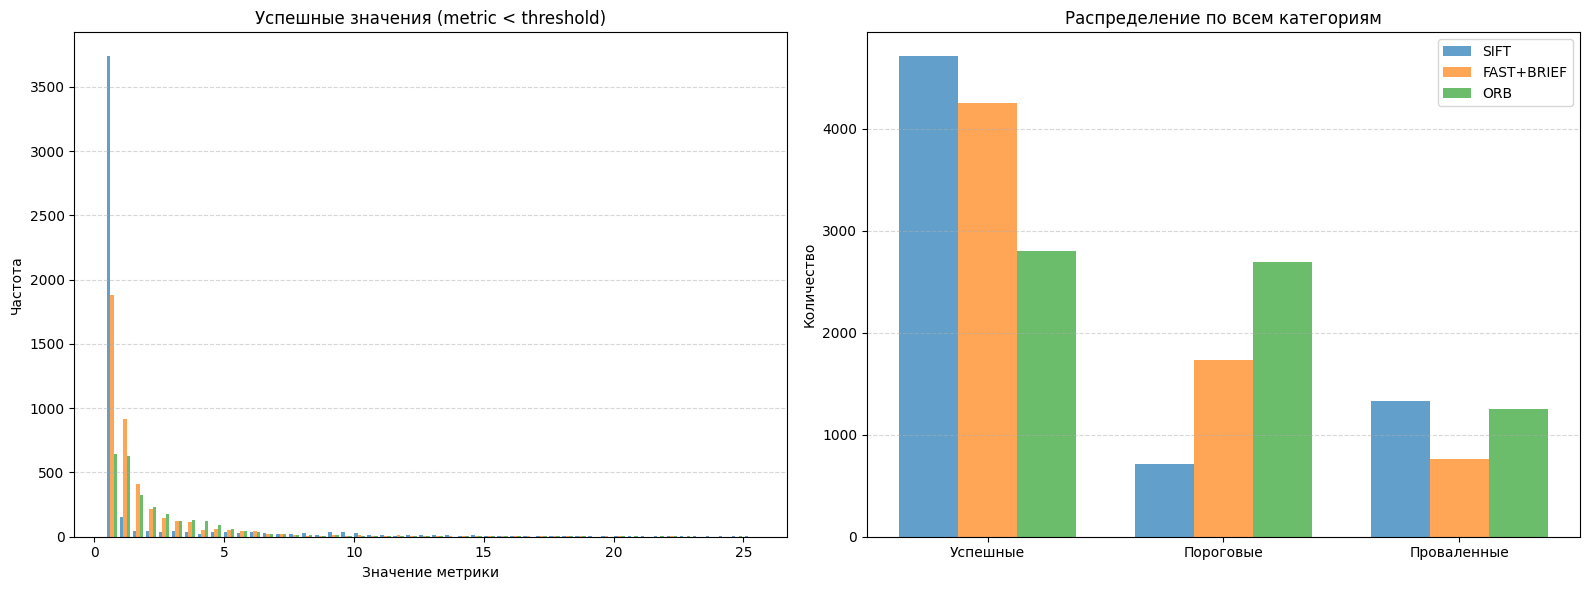

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

metric = 'loss_2'

grouped = df.groupby('feature_matcher', sort=False)
names, loss_multi = zip(*grouped[metric])
success_multi = [loss[loss < loss_threshold] for loss in loss_multi]

ax1.hist(success_multi, 50, histtype='bar', alpha=0.7)
ax1.set_title('Успешные значения (metric < threshold)')
ax1.set_xlabel('Значение метрики')
ax1.set_ylabel('Частота')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

colors = plt.cm.tab10(np.linspace(0, 1, len(grouped)))
categories = ['Успешные', 'Пороговые', 'Проваленные']
bar_width = 0.25
x = np.arange(len(categories))

summary_data = []
for name, group in grouped:
    metrics = group[metric]
    success = (metrics < loss_threshold).sum()
    threshold = ((metrics >= loss_threshold) & metrics.notna()).sum()
    failed = metrics.isna().sum()
    summary_data.append((success, threshold, failed))

for i, (name, (success, threshold, failed)) in enumerate(zip(grouped.groups.keys(), summary_data)):
    ax2.bar(x + i * bar_width, [success, threshold, failed],
            width=bar_width,
            alpha=0.7,
            label=name)

ax2.set_title('Распределение по всем категориям')
ax2.set_xticks(x + bar_width*(len(grouped)-1)/2)
ax2.set_xticklabels(categories)
ax2.set_ylabel('Количество')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('img/main_distortion')
plt.show()

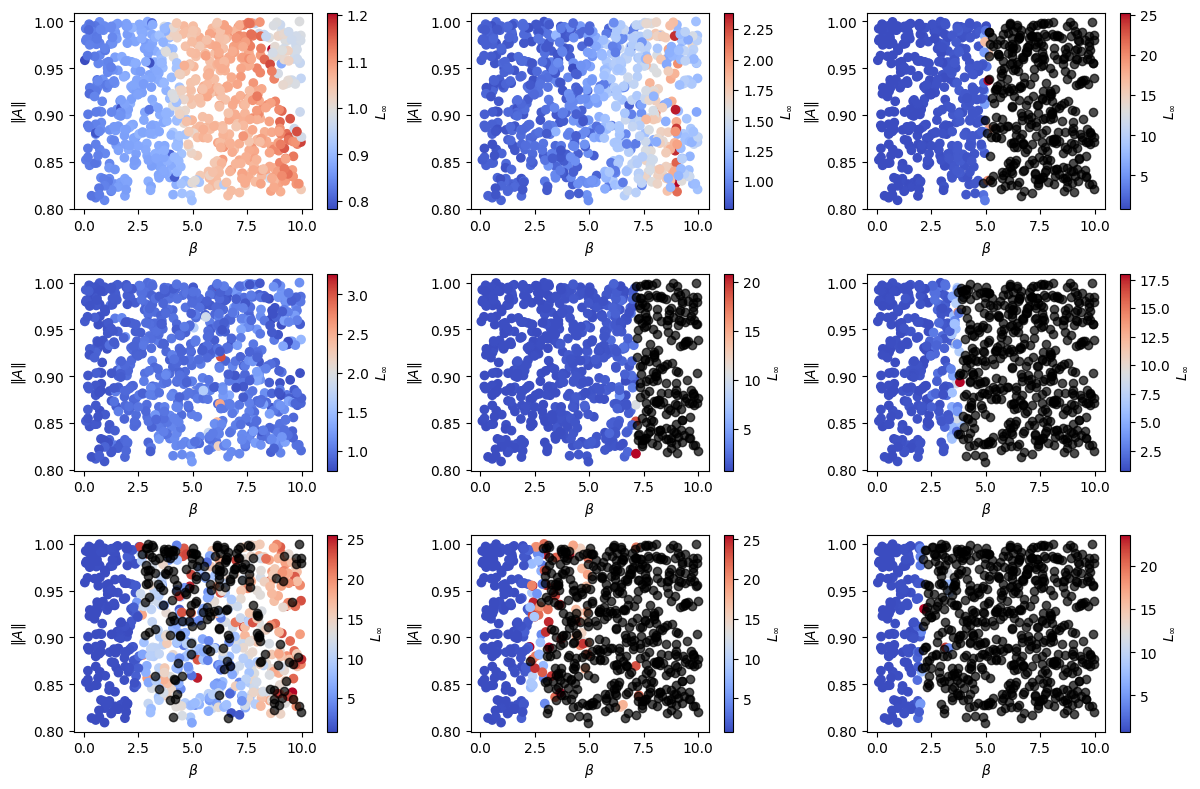

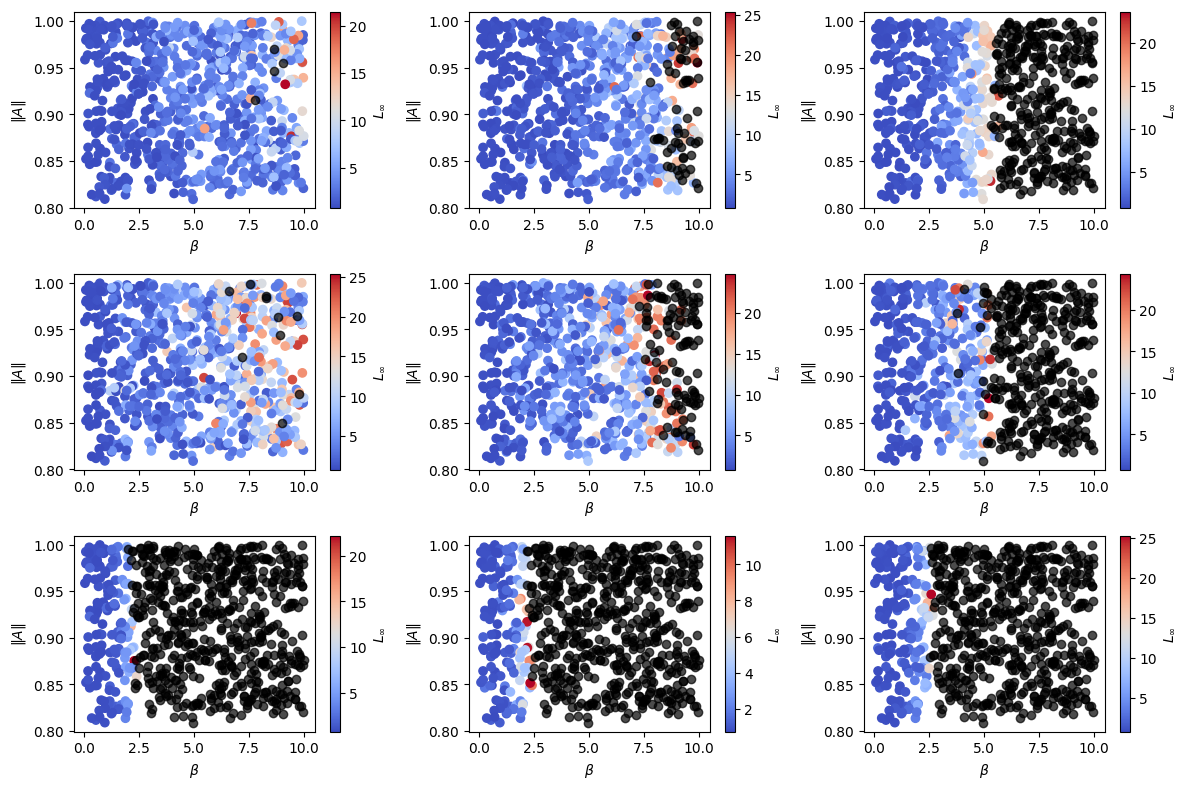

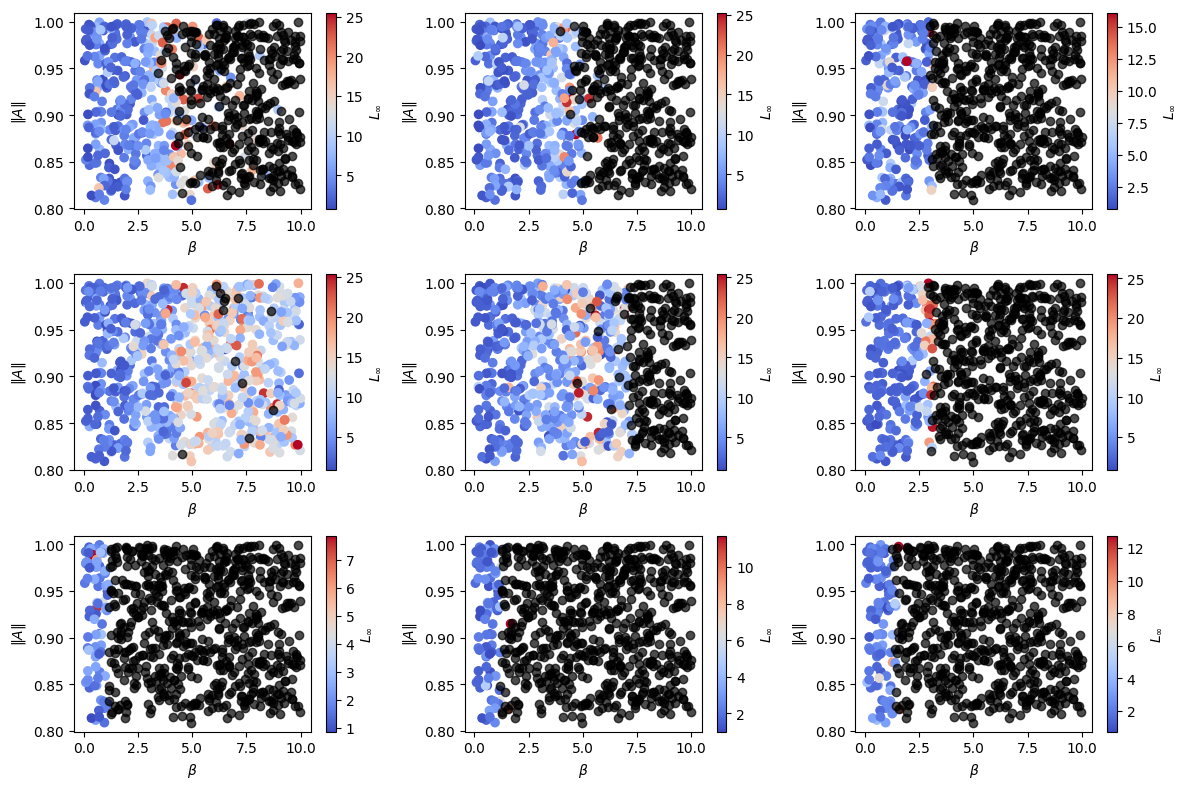

In [18]:
df['atmospheric_mean'] = [np.mean(i) for i in df['atmospheric_light']]
param1 = 'beta'
param2 = 'atmospheric_light_mean'
metric = 'loss_inf_processed'

tables = []
for name, group in df.groupby('feature_matcher', sort=False):
    n_cols = 3
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]
    notna_proportions = []
    for ax, (name1, group1) in zip(axes, group.groupby('density_type')):
        notna_proportion = group1[metric].notna().mean()
        notna_proportions.append(notna_proportion)
        c = group1[metric]
        scatter = ax.scatter(group1[param1], group1[param2], c=c, cmap='coolwarm')
        # , label=str(name) + ' & ' + str(name1) + f' ({notna_proportion:.2f})', alpha=0.7
        na = group1[group1[metric].isna()]
        ax.scatter(na[param1], na[param2], alpha=0.7, color='black')
        ax.set_xlabel(r'$\beta$')
        ax.set_ylabel(r'$\| A \|$')
        plt.colorbar(scatter, label='$L_\infty$')
        # ax.legend()
    tables.append(np.array(notna_proportions).reshape(3,3))
    plt.tight_layout()
    plt.savefig(f'img/{name}loss(beta,a)')
    plt.show()

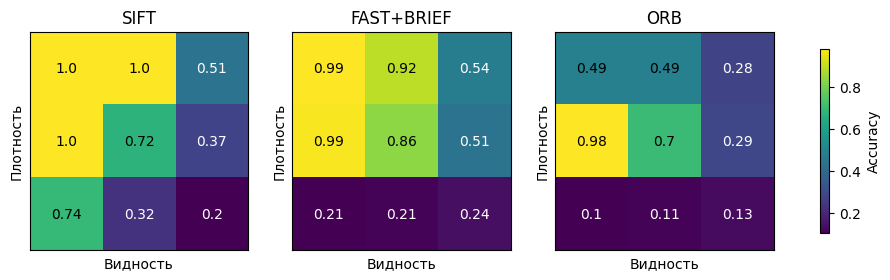

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(tables), figsize=(12, 4))

for idx, (fm, ax, array) in enumerate(zip(fms, axes, tables)):
    title = str(fm)
    cax = ax.matshow(array)
    ax.set_title(title)
    ax.set_xlabel('Видность')
    ax.set_ylabel('Плотность')
    for (i, j), val in np.ndenumerate(array):
        ax.text(j, i, f'{round(val,2)}', ha='center', va='center', 
            color='white' if val < np.mean(array) else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

fig.colorbar(cax, ax=axes, shrink=0.6, label='Accuracy')
# plt.tight_layout()
plt.savefig('img/fixed_distortion_cmap')
plt.show()

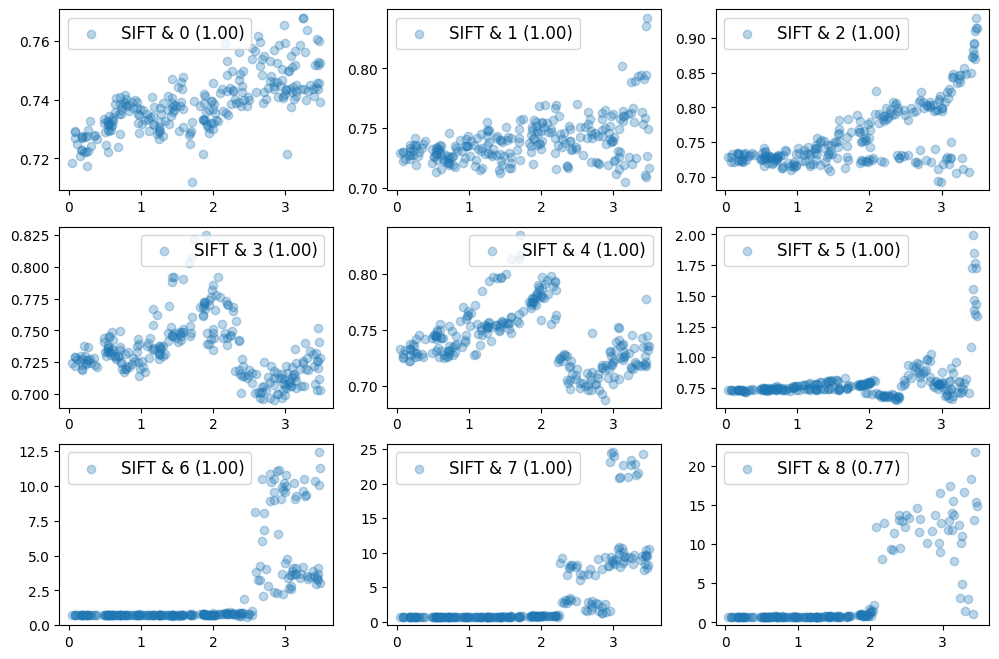

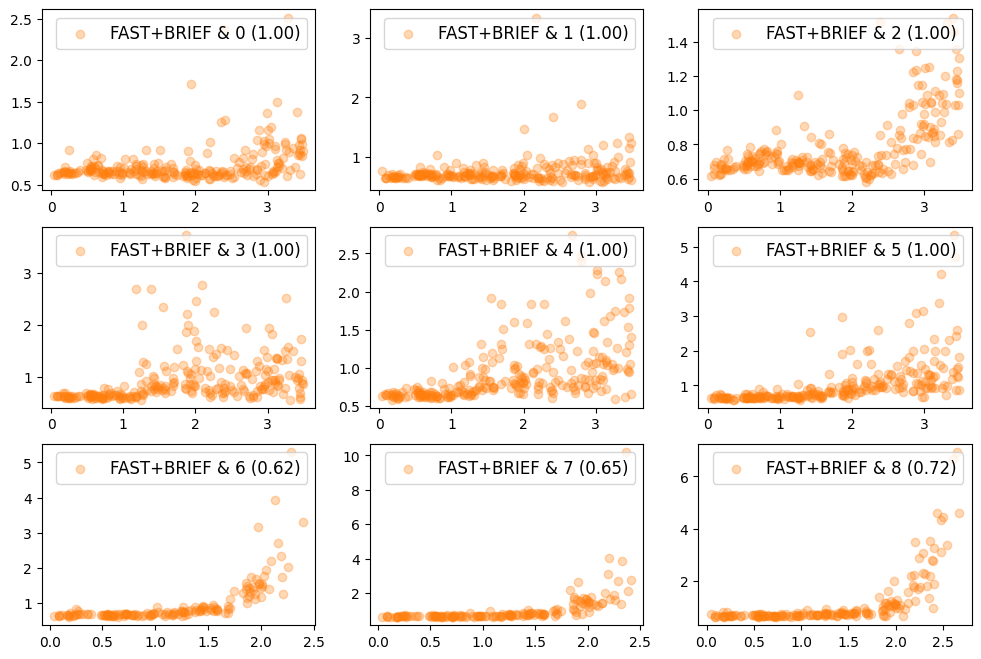

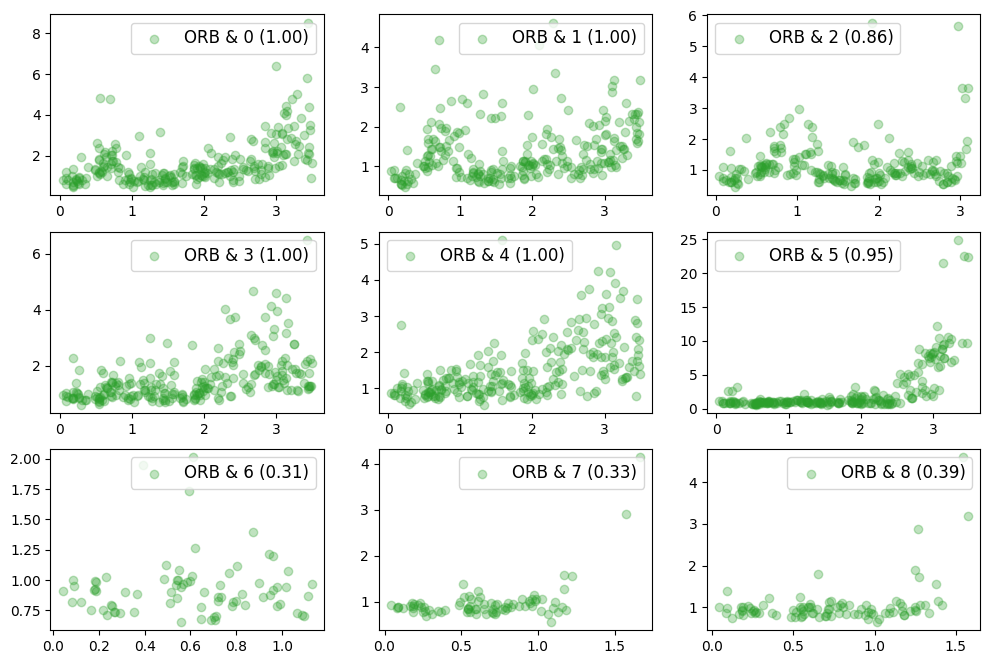

In [20]:
df['atmospheric_light_stat'] = [(np.max(i) - np.min(i)) / (np.max(i) + np.min(i)) for i in df['atmospheric_light']]
param = 'beta'
metric = 'loss_2_processed'

for i, (name, group) in enumerate(df.groupby('feature_matcher', sort=False)):
    n_cols = 3
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]
    for ax, (name1, group1) in zip(axes, group.groupby('density_type')):
        group1_filtered = group1[group1['beta'] < 3.5]
        notna_proportion = group1_filtered[metric].notna().mean()
        ax.scatter(group1_filtered[param], group1_filtered[metric], label=str(name) + ' & ' + str(name1) + f' ({notna_proportion:.2f})', alpha=0.3, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        ax.legend(fontsize=12)
    plt.savefig(f'img/{name}loss(beta)')
    plt.show()

In [21]:
img_real_clean1 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/clean/f210402t01p00r08_sc01_RGB_c1.jpeg'), cv2.COLOR_BGR2RGB)
img_real_hazed1 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/hazed/f210324t01p00r10_sc01_RGB_h1.jpeg'), cv2.COLOR_BGR2RGB)
img_real_clean2 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/clean/f210402t01p00r08_sc01_RGB_c2.jpeg'), cv2.COLOR_BGR2RGB)
img_real_hazed2 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/hazed/f210324t01p00r10_sc01_RGB_h2.jpeg'), cv2.COLOR_BGR2RGB)
img_real_clean3 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/clean/f210402t01p00r08_sc01_RGB_c3.jpeg'), cv2.COLOR_BGR2RGB)
img_real_hazed3 = cv2.cvtColor(cv2.imread('real_haze_images/crops/flight_1/hazed/f210324t01p00r10_sc01_RGB_h3.jpeg'), cv2.COLOR_BGR2RGB)
pairs = [(img_real_clean1, img_real_hazed1), (img_real_clean2, img_real_hazed2), (img_real_clean3, img_real_hazed3)]

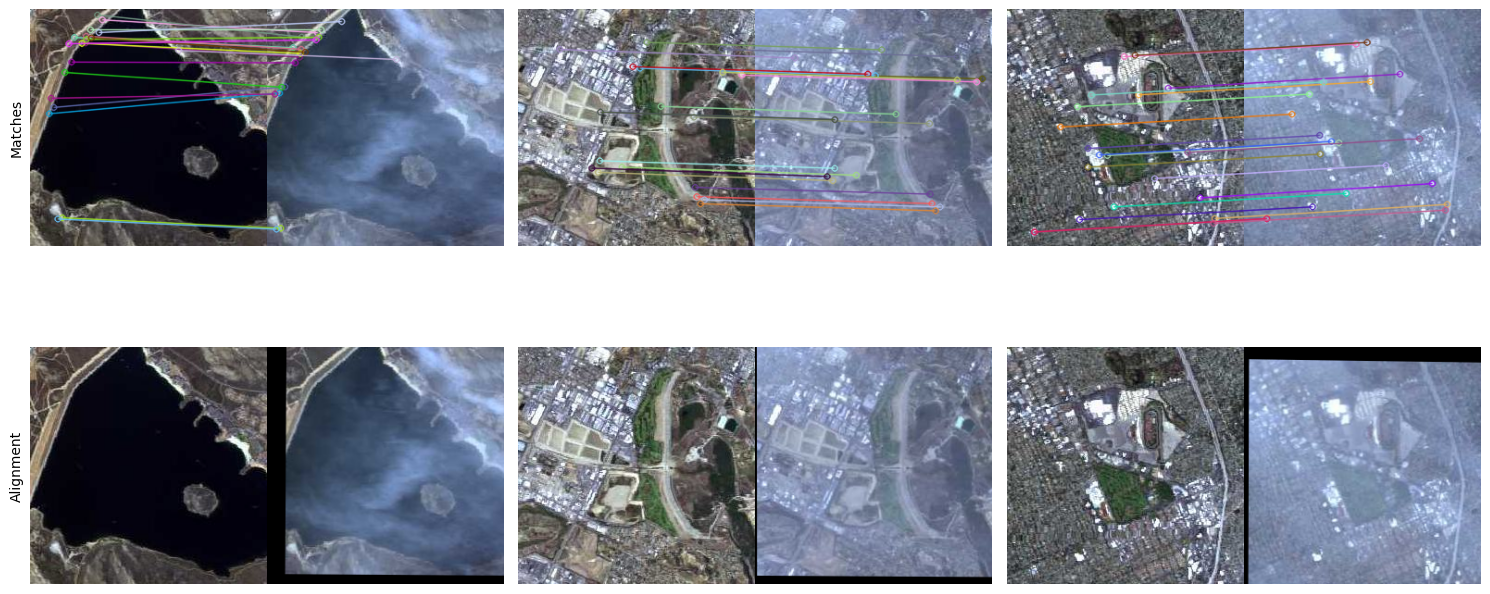

In [ ]:
matcher = SIFTFeatureMatcher()

plt.figure(figsize=(15, 8))
for pair_idx, (img_real_clean, img_real_hazed) in enumerate(pairs[:3]):
    
    results = matcher.process_images(img_real_clean, img_real_hazed)
    
    matched_vis = cv2.drawMatches(
        img_real_clean, results['keypoints1'],
        img_real_hazed, results['keypoints2'],
        results['matches'][:20], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    matrix_alg = results['matrix_alg']
    img_alg = cv2.warpPerspective(img_real_hazed, matrix_alg, (w, h))
    aligned_vis = np.hstack((img_real_clean, img_alg))
    
    plt.subplot(2, 3, pair_idx + 1)
    plt.imshow(matched_vis)
    if pair_idx == 0:
        plt.ylabel('Matches')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    
    plt.subplot(2, 3, pair_idx + 4)
    if pair_idx == 0:
        plt.ylabel('Alignment')
    
    plt.imshow(aligned_vis)

    # plt.axis('off')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(f'img/SIFT_real_haze_matches')
plt.show()